In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import argparse
import matplotlib.pyplot as plt

In [30]:
# TODO (After Finals):
# - Add learning rate schedule
# - Add momentum schedule
# - Try different momentum (Nesterov, etc)
# - Benchmark GPU times, AWS p3.2xlarge spot instance
# - Try out superconvergence (Smith & Topin)
# - Bayesian optimization hyperparameter search

# Hyperparameters

In [170]:
# Hyperparameters
parser = argparse.ArgumentParser(description='PyTorch MNIST')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='# of batches to cycle before logging training status')
args = parser.parse_args("--epochs=10 --log-interval=100 --no-cuda".split())  # parsing is for .py, kept here with manual parse_args for consistency

In [109]:
# CUDA Setup
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [110]:
# Manual Seed
torch.manual_seed(args.seed)

# Loading MNIST

In [111]:
# Mean and Standard Deviation of MNIST
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)
MNIST_mean = train_set.train_data.float().mean()/255
MNIST_std = train_set.train_data.float().std()/255

Since MNIST is an unusual image dataset (gray scale with virtually only two colors: black and white), we examine the mean and standard deviation of the dataset, which turn out to be 0.1307 and 0.3081, respectively. We will use these to normalize the dataset.

In [112]:
# Dataset
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((MNIST_mean,), (MNIST_std,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((MNIST_mean,), (MNIST_std,))
                   ])),
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

We use Pytorch's DataLoader functionality to split the MNIST dataset to training and test splits automatically (from their raw partitions), convert them into tensors, and then normalize them. We also choose to shuffle the training dataset. This helps reduce variance and addresses the nonconvexity of the loss landscape by (hypothetically) avoiding local minimizers that don't generalize well. Also, by shuffling the data that is put into our minibatches, we decrease the likelihood that our gradients derived from our minibatches are unrepresentative of the true gradient. 

# Convolutional Neural Net Model

In [155]:
# Model
class Net(nn.Module):
    """ Simple Convolutional Neural Net (inspired by LeNet) """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=2, stride=2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

In this model that was heavily inspired by LeNet-5, we have 3 convolutional layers which are each followed by a maxpool and relu (except for the last one which doesn't have a maxpool), and then one final fully connected layer and a relu activation before the final output layer, with a softmax activation. We also drew inspiration and guidance from the "Convnet Architectures" section of Stanford's course on Convolutional Neural Networks for Computer Vision "http://cs231n.github.io/convolutional-networks/".

In [156]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

We use SGD as our optimizer with fixed learning rate and momentum. Dynamic learning rate and momentum schedules have been shown to help improve generalization performance in certain scenarios, but these are probably overkill for something like MNIST. Nevertheless, it is something interesting to try in the future.

# Training Loop

In [157]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # zero out the gradients (they accumulate)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Epoch: {} {}/{} ({:.0f}%)\tLoss: {:.3f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

As briefly mentioned above, we use minibatches to take advantage of the efficiency of SGD while not sacrificing the generalization performance of full gradient descent. For each training batch, we compute the loss (we use negative log-likelihood for simplicity, since we covered this in class), compute the gradients through backprop, and then allow SGD to adjust the weights of our network accordingly. When we run through all examples in our training set, we finish what we call one epoch, and we start a new epoch again.

# Test Performance

In [161]:
losses = []
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    losses.append(test_loss)
    print('\nTest: Average loss: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Here we simply calculate the loss on our test set. This function is called every training epoch to give us a handle on the generalization over time. The code is very straightforward and is virtually unchanged for any classifier. Thus we take an almost identical approach to that taken in the PyTorch documentation/tutorial.

In [171]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()

Epoch: 1 0/60000 (0%)	Loss: 0.197
Epoch: 1 6400/60000 (11%)	Loss: 0.183
Epoch: 1 12800/60000 (21%)	Loss: 0.167
Epoch: 1 19200/60000 (32%)	Loss: 0.071
Epoch: 1 25600/60000 (43%)	Loss: 0.063
Epoch: 1 32000/60000 (53%)	Loss: 0.094
Epoch: 1 38400/60000 (64%)	Loss: 0.041
Epoch: 1 44800/60000 (75%)	Loss: 0.016
Epoch: 1 51200/60000 (85%)	Loss: 0.091
Epoch: 1 57600/60000 (96%)	Loss: 0.063

Test: Average loss: 0.106, Accuracy: 9662/10000 (97%)

Epoch: 2 0/60000 (0%)	Loss: 0.168
Epoch: 2 6400/60000 (11%)	Loss: 0.088
Epoch: 2 12800/60000 (21%)	Loss: 0.112
Epoch: 2 19200/60000 (32%)	Loss: 0.105
Epoch: 2 25600/60000 (43%)	Loss: 0.078
Epoch: 2 32000/60000 (53%)	Loss: 0.144
Epoch: 2 38400/60000 (64%)	Loss: 0.048
Epoch: 2 44800/60000 (75%)	Loss: 0.092
Epoch: 2 51200/60000 (85%)	Loss: 0.032
Epoch: 2 57600/60000 (96%)	Loss: 0.154

Test: Average loss: 0.104, Accuracy: 9671/10000 (97%)

Epoch: 3 0/60000 (0%)	Loss: 0.055
Epoch: 3 6400/60000 (11%)	Loss: 0.051
Epoch: 3 12800/60000 (21%)	Loss: 0.162
Epoch: 3 

Text(0.5,0,'Epoch')

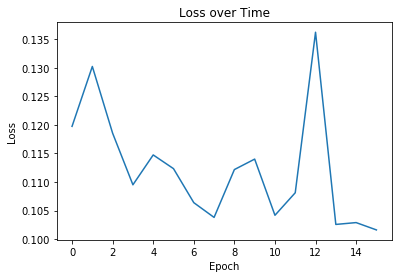

In [177]:
plt.plot(losses)
plt.title("Loss over Time")
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Discussion

We find that we can achieve much higher performance on MNIST using CNNs vs. linear SVMs (97% vs. 86%). It may not be the case that linear SVMs are worse, and that we spent more time on figuring out how to improve the performance of CNNs, but it is striking how different the approaches of coding up these two classifiers are (in spite of being able to use a toolbox for each).
 
In simple cases like this, convolutional neural networks are also quite a more initialization-dependent than SVMs (in terms of the parameterization of the network). It is not straightforward for a beginner to understand what kind of architectures do and do not work, and it is practically necessary to try and build off of the architecture of someone else (i.e LeNet 5).

We also find that increasing the number of epochs doesn't strictly and simply increase performance. This may be because we might land in a minimizer even before the first epoch is over- suggesting that reaching something like 97% performance only requires a single runthrough of the data.